In [16]:
import tensorflow as tf
import math
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os

from tensorflow.keras import layers
from tensorflow import keras

In [2]:
image_size = 32
dataset_repetitions = 5
num_classes=10
channels = 1

kid_image_size = 75 # kernel inception distance (KID)
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_min_freq = 1.0
embedding_max_freq = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4


In [140]:
def preprocess(image, label):
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    crop_size = tf.minimum(height, width)
    
    # crop image
    image = tf.image.crop_to_bounding_box(image, 
                                         (height - crop_size) // 2,
                                         (width - crop_size) // 2,
                                         crop_size, crop_size)
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, (image_size, image_size), antialias=True)
    image = tf.clip_by_value(image / 255.0, 0.0, 1.0)
    return image, label

def get_datasets():

    train_ds, val_ds = tfds.load('mnist',
                                 split=['train[:90%]', 'train[90%:]'],
                                as_supervised=True, shuffle_files=True)

    # Normalize to [-1, 1], shuffle and batch
    train_ds, val_ds = train_ds.map(preprocess), val_ds.map(preprocess)
    train_ds = train_ds.cache().shuffle(10*batch_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Return numpy arrays instead of TF tensors while iterating
    return train_ds, val_ds

In [141]:
train_ds, val_ds = get_datasets()

In [142]:
len(train_ds)

844

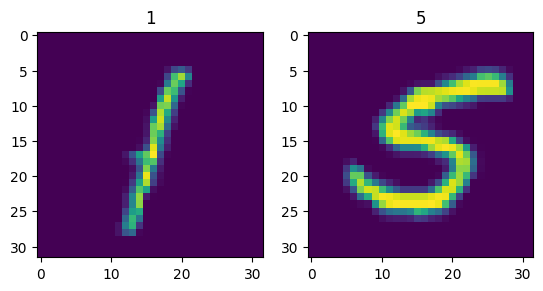

In [143]:
for image, labels in train_ds.take(1):
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(image[i])
        plt.title(labels[i].numpy())

In [144]:
sample_image, sample_labels = train_ds.as_numpy_iterator().next()

In [145]:
sample_image.shape

(64, 32, 32, 1)

In [146]:
class KID(keras.metrics.Metric):
    def __init__(self, name):
        super(KID, self).__init__(name=name)
        
        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name='kid_tracker')
        
        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )
        
    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0
    

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)

        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)

        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )

        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
            ) / (batch_size_f * (batch_size_f - 1.0))
        
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross
        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()
    

In [10]:
class SinusoidalEmb(layers.Layer):
    def __init__(self, **kwargs):
        super(SinusoidalEmb, self).__init__(**kwargs)
        
    def call(self, x):
        x = tf.cast(x, tf.float32)
        frequencies = tf.exp(
            tf.linspace(
                tf.math.log(embedding_min_freq),
                tf.math.log(embedding_max_freq),
                embedding_dims // 2,
            )
        )
        angular_speeds = 2.0 * math.pi * frequencies
        embeddings = tf.concat(
            [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3)
        return embeddings   
    
def ConditionalRes(num_channels=1):
    def apply(x, y):
        res = x.shape[1]
        y = layers.Dense((res*res*num_channels))(y)
        y = layers.ReLU()(y)
        y = layers.Reshape((res, res, num_channels))(y)

        return y
    return apply
    
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply



In [11]:
def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, channels))
    noise_variances = keras.Input(shape=(1, 1, 1))
    labels = keras.Input(shape=(1,))

    e = SinusoidalEmb()(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])
    
    embeddings = layers.Embedding(num_classes, 64)(labels)
    skips = []
    for width in widths[:-1]:
        cv = ConditionalRes()(x, embeddings)
        x = tf.concat([x, cv], axis=-1)
        x = DownBlock(width, block_depth)([x, skips])

    cv = ConditionalRes()(x, embeddings)
    x = tf.concat([x, cv], axis=-1)
    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        cv = ConditionalRes()(x, embeddings)
        x = tf.concat([x, cv], axis=-1)
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(channels, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model(inputs=[noisy_images, noise_variances, labels], outputs=x)


In [12]:
unet = get_network(image_size, widths, 2)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 1, 1)]    0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 64)        640         ['input_3[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                              

                                                                                                  
 add_3 (Add)                    (None, 16, 16, 64)   0           ['conv2d_10[0][0]',              
                                                                  'add_2[0][0]']                  
                                                                                                  
 re_lu_2 (ReLU)                 (None, 1, 64)        0           ['dense_2[0][0]']                
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 8, 8, 64)    0           ['add_3[0][0]']                  
 oling2D)                                                                                         
                                                                                                  
 reshape_2 (Reshape)            (None, 8, 8, 1)      0           ['re_lu_2[0][0]']                
          

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 225)   450         ['concatenate_1[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv2d_22 (Conv2D)             (None, 8, 8, 96)     194496      ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_23 (Conv2D)             (None, 8, 8, 96)     83040       ['conv2d_22[0][0]']              
                                                                                                  
 conv2d_21 (Conv2D)             (None, 8, 8, 96)     21696       ['concatenate_1[0][0]']          
                                                                                                  
 add_8 (Ad

 batch_normalization_12 (BatchN  (None, 32, 32, 97)  194         ['concatenate_5[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 conv2d_34 (Conv2D)             (None, 32, 32, 32)   27968       ['batch_normalization_12[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_34[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)             (None, 32, 32, 32)   3136        ['concatenate_5[0][0]']          
                                                                                                  
 add_12 (Add)                   (None, 32, 32, 32)   0           ['conv2d_35[0][0]',              
          

In [162]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super(DiffusionModel, self).__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        #self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)
        
        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, labels, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        
        network = self.network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2, labels], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, labels, diffusion_steps):
        # reverse diffusion = sampling
        num_images = tf.shape(initial_noise)[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, labels, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step
    
        return pred_images

    def generate(self, num_images, labels, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, channels))
        generated_images = self.reverse_diffusion(initial_noise, labels, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, batch):
        images, labels = batch
        batch_s= tf.shape(images)[0]
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_s, image_size, image_size, channels))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_s, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, labels, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        '''for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)'''

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, batch):
        images, labels = batch
        batch_s = tf.shape(images)[0]
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_s, image_size, image_size, channels))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_s, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, labels, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            batch_s, labels, kid_diffusion_steps)
        
        #self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        num_images=num_rows * num_cols
        labels = tf.random.uniform([num_images, 1], minval=0, maxval=9, dtype=tf.int32)
        generated_images = self.generate(
            num_images=num_images,
            labels=labels,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.title(labels[index][0].numpy())
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()
        
    def save_images(self, images, step, num_rows=3, num_cols=6):
        images = self.denormalize(images)
        if os.path.exists('saved_images'):
            pass
        else:
            os.mkdir('saved_images')
        
        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.savefig(f'saved_images/image at step {step}.jpg')
        plt.show()
        plt.close()

In [163]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)

In [164]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [165]:
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=rmse)

Epoch 1/10
844/844 [==============================] - ETA: 0s - n_loss: 0.2110 - i_loss: 0.6324

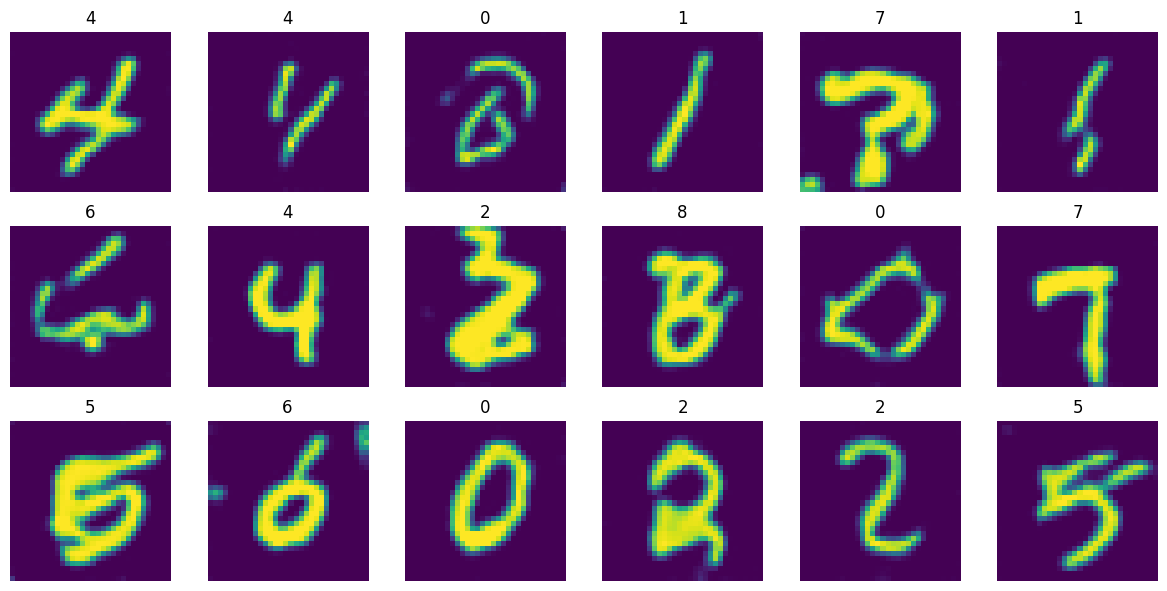

844/844 [==============================] - 3368s 4s/step - n_loss: 0.2110 - i_loss: 0.6324 - val_n_loss: 0.1726 - val_i_loss: 0.4159 - val_kid: 0.0000e+00
Epoch 2/10
844/844 [==============================] - ETA: 0s - n_loss: 0.1710 - i_loss: 0.4138

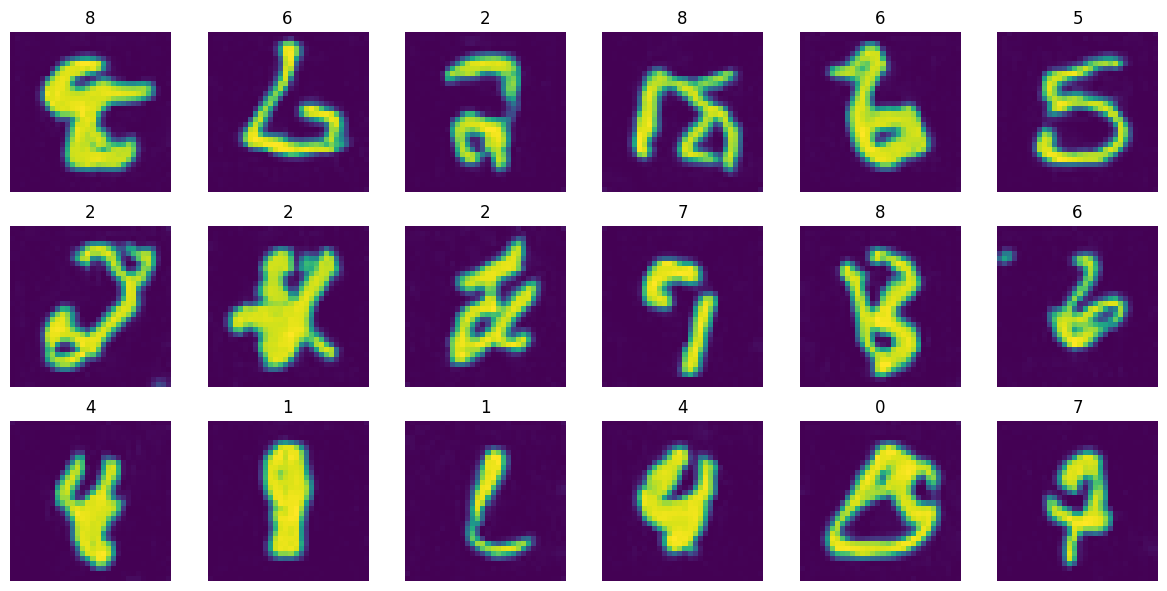

844/844 [==============================] - 3292s 4s/step - n_loss: 0.1710 - i_loss: 0.4138 - val_n_loss: 0.1694 - val_i_loss: 0.3724 - val_kid: 0.0000e+00
Epoch 3/10
844/844 [==============================] - ETA: 0s - n_loss: 0.1661 - i_loss: 0.3903

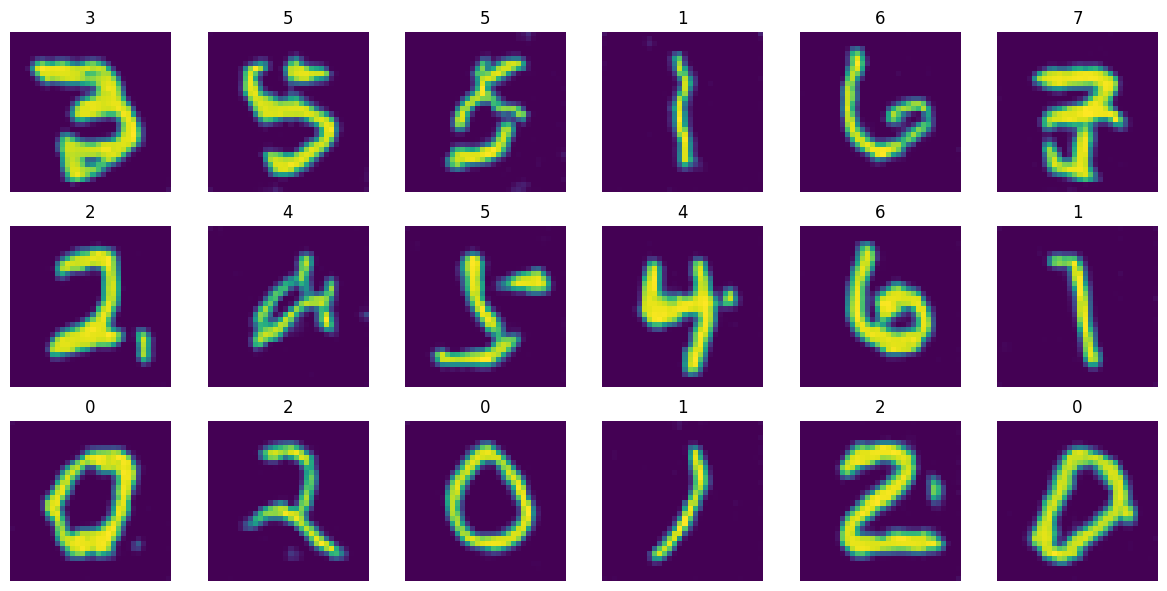

844/844 [==============================] - 3305s 4s/step - n_loss: 0.1661 - i_loss: 0.3903 - val_n_loss: 0.1667 - val_i_loss: 0.3663 - val_kid: 0.0000e+00
Epoch 4/10
844/844 [==============================] - ETA: 0s - n_loss: 0.1630 - i_loss: 0.3727

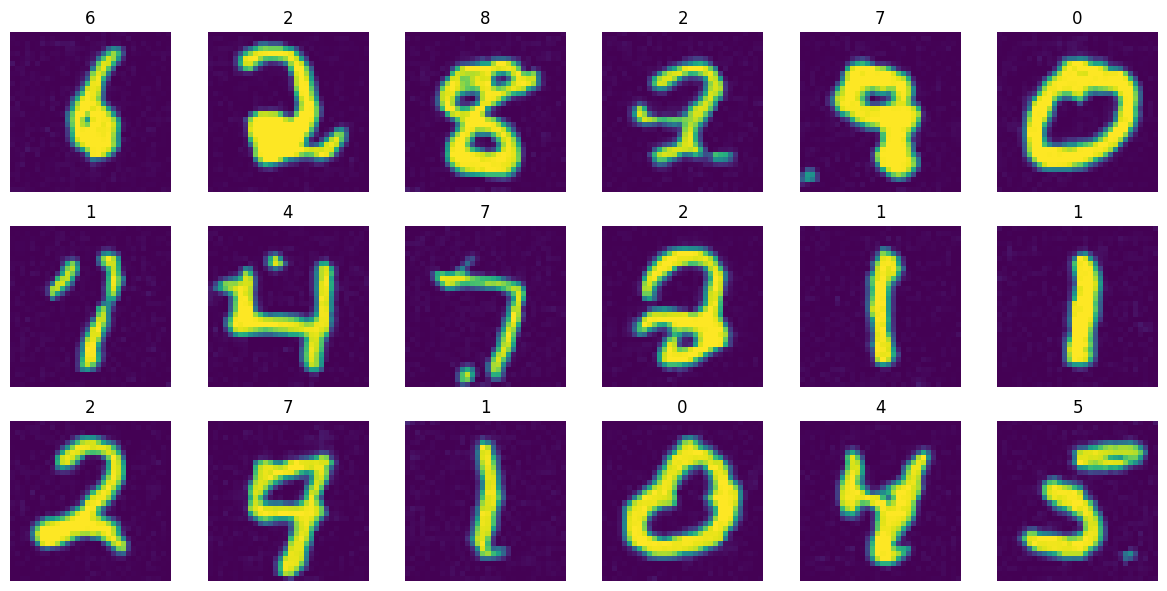

844/844 [==============================] - 3305s 4s/step - n_loss: 0.1630 - i_loss: 0.3727 - val_n_loss: 0.1646 - val_i_loss: 0.3688 - val_kid: 0.0000e+00
Epoch 5/10
844/844 [==============================] - ETA: 0s - n_loss: 0.1613 - i_loss: 0.3689

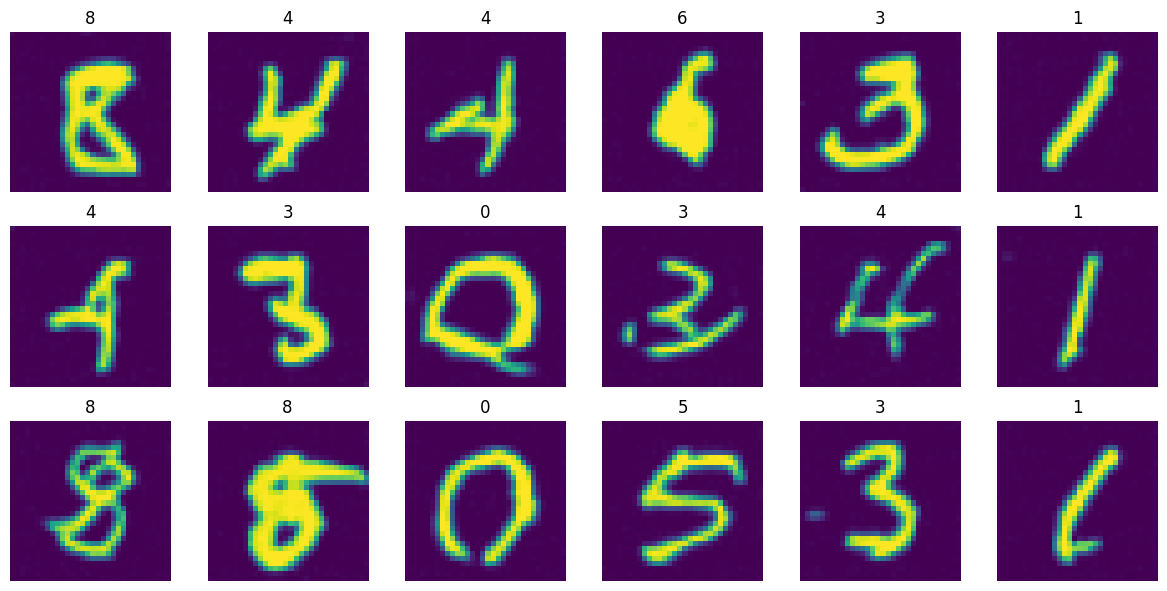

844/844 [==============================] - 3335s 4s/step - n_loss: 0.1613 - i_loss: 0.3689 - val_n_loss: 0.1603 - val_i_loss: 0.3423 - val_kid: 0.0000e+00
Epoch 6/10
844/844 [==============================] - ETA: 0s - n_loss: 0.1597 - i_loss: 0.3608

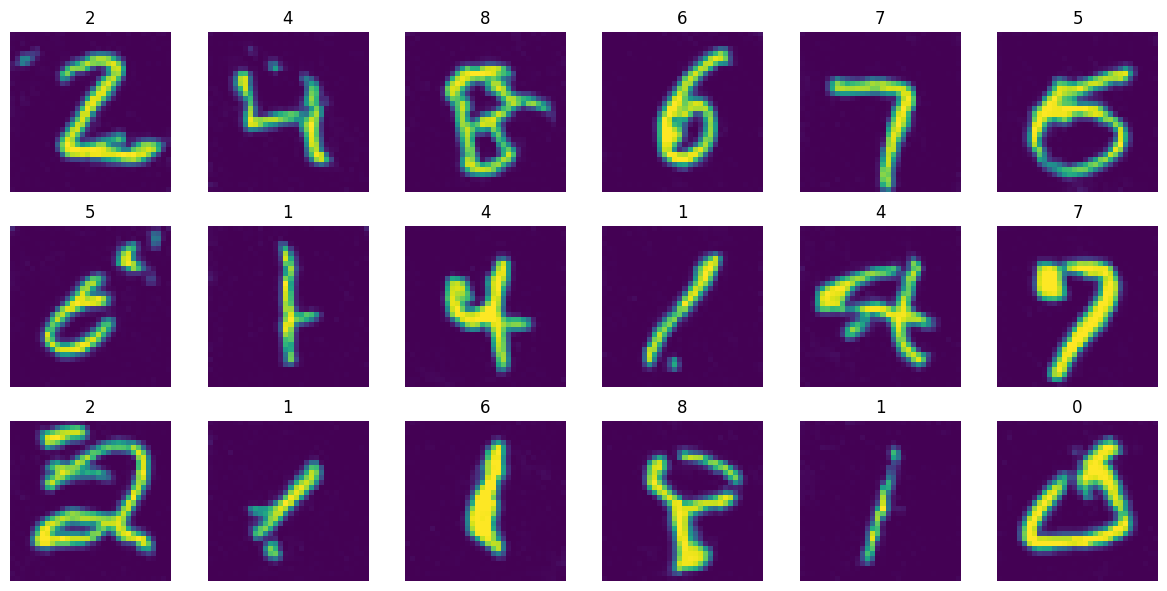

844/844 [==============================] - 3295s 4s/step - n_loss: 0.1597 - i_loss: 0.3608 - val_n_loss: 0.1587 - val_i_loss: 0.3608 - val_kid: 0.0000e+00
Epoch 7/10
721/844 [========================>.....] - ETA: 7:47 - n_loss: 0.1579 - i_loss: 0.3584

KeyboardInterrupt: 

In [49]:
# pixelwise mean absolute error is used as loss
# save the best model based on the validation KID metric
checkpoint_path = "checkpoints/diffusion_model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_ds.map(lambda x, y:x))

# run training and plot generated images periodically
model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

In [157]:
# create our checkopint manager
ckpt = tf.train.Checkpoint(model)
ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=2)

# load from a previous checkpoint if it exists, else initialize the model from scratch
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    #start_interation = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")


Restored from ./checkpoints\diffusion_model


In [160]:
model.evaluate(val_ds.take(6))

6/6 [==============================] - 36s 1s/step - n_loss: 0.1725 - i_loss: 0.4498 - kid: 0.0000e+00


[0.17249710857868195, 0.44975876808166504, 0.0]

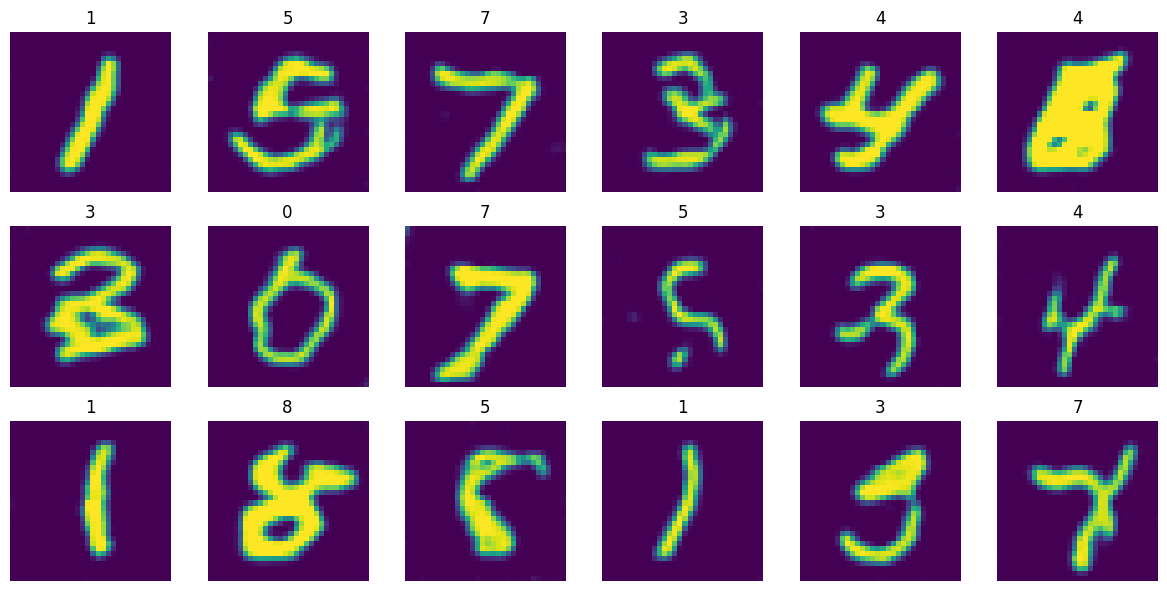

In [161]:
model.plot_images()

In [94]:
def save_images(num_rows, num_cols, diffusion_steps):
    batch_s = num_rows*num_cols
    # reverse diffusion = sampling
    initial_noise = tf.random.normal([batch_s, 32, 32, channels])
    labels = tf.random.uniform([batch_s, 1], minval=0, maxval=9, dtype=tf.int32)
    num_images = tf.shape(initial_noise)[0]
    step_size = 1.0 / diffusion_steps

    # important line:
    # at the first sampling step, the "noisy image" is pure noise
    # but its signal rate is assumed to be nonzero (min_signal_rate)
    next_noisy_images = initial_noise
    for step in range(diffusion_steps):
        noisy_images = next_noisy_images

        # separate the current noisy image to its components
        diffusion_times = tf.ones((batch_s, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = model.diffusion_schedule(diffusion_times)
        pred_noises, pred_images = model.denoise(
            noisy_images, noise_rates, labels, signal_rates, training=False
        )
        # network used in eval mode

        # remix the predicted components using the next signal and noise rates
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = model.diffusion_schedule(
            next_diffusion_times
        )
        next_noisy_images = (
            next_signal_rates * pred_images + next_noise_rates * pred_noises
        )
        model.save_images(pred_images, step, num_rows=num_rows, num_cols=num_cols)
        

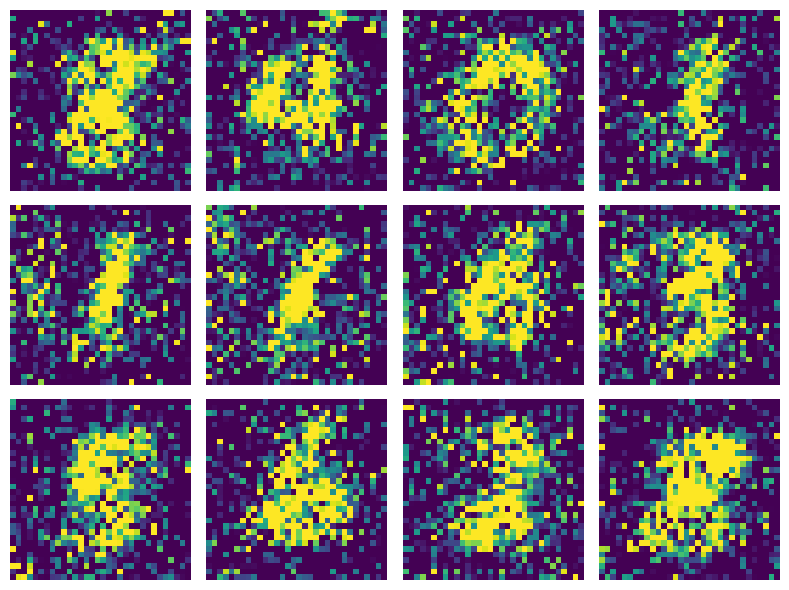

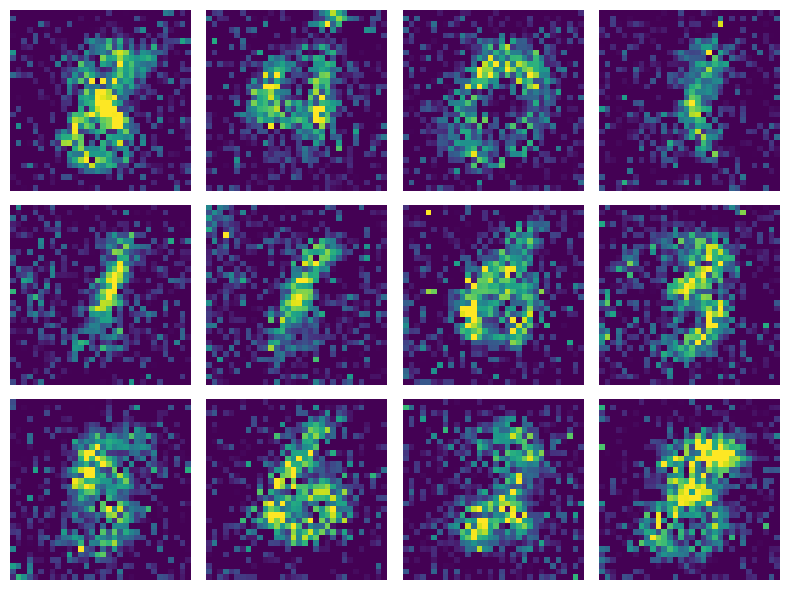

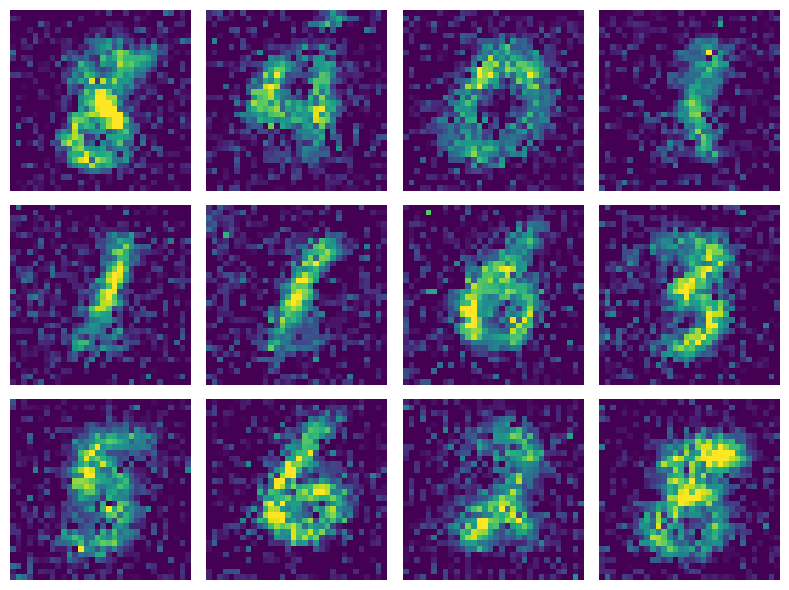

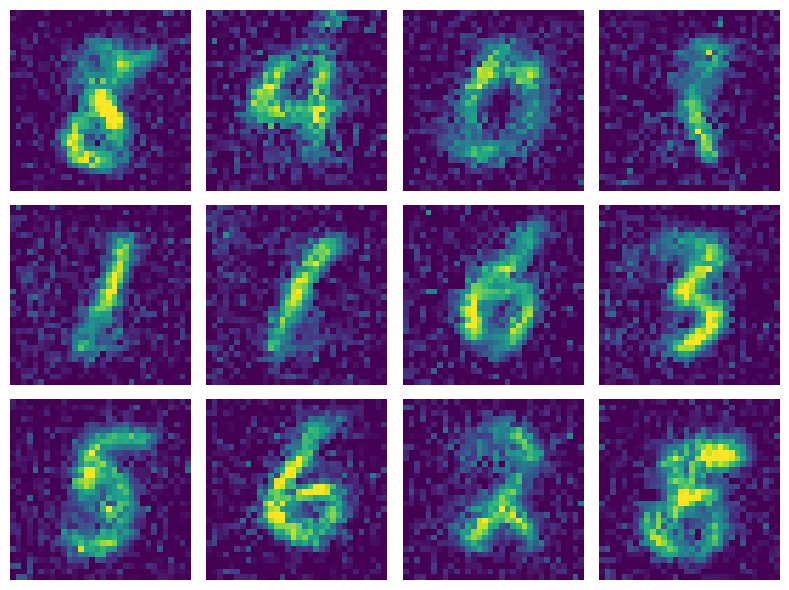

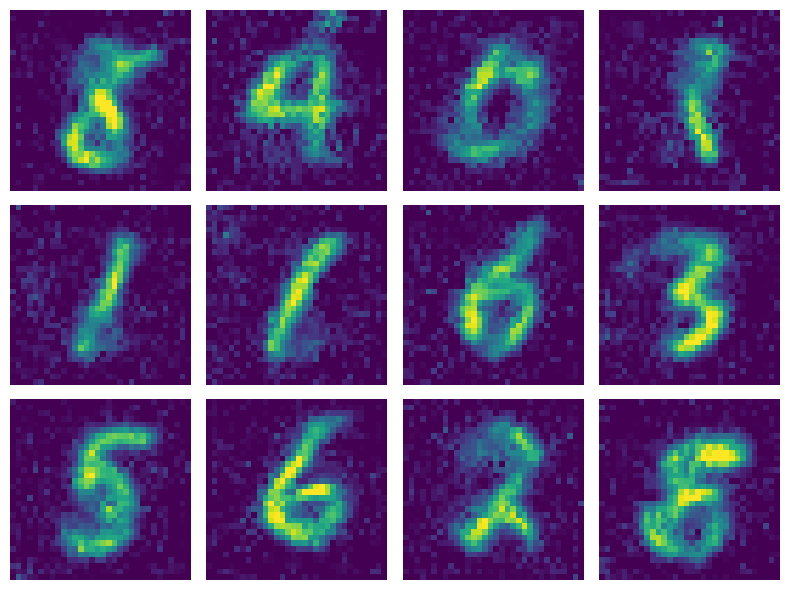

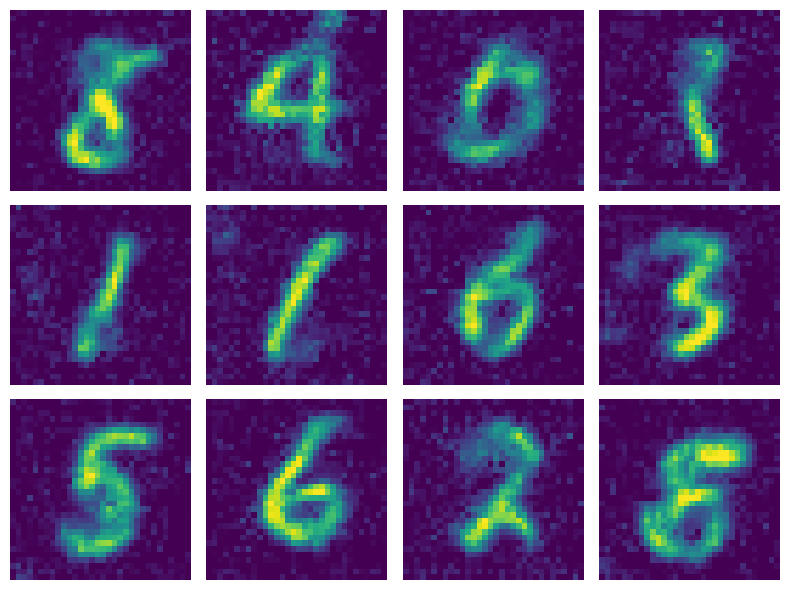

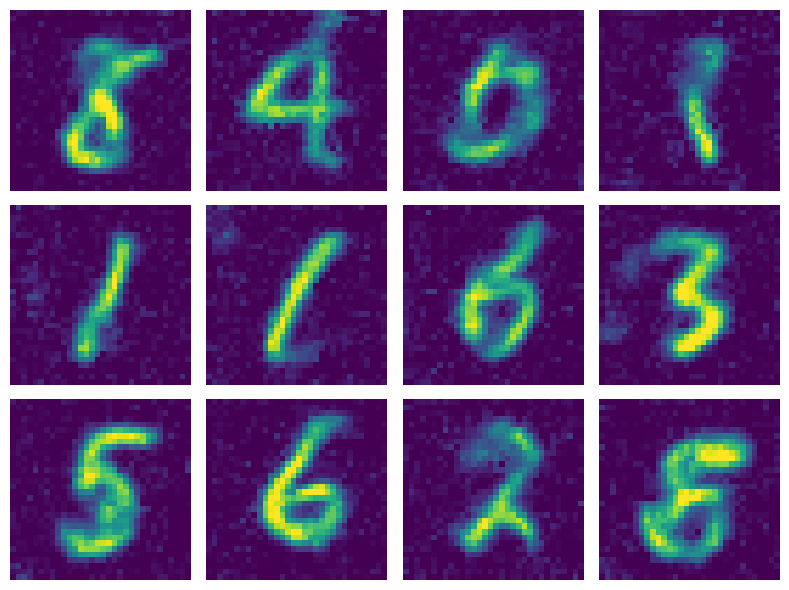

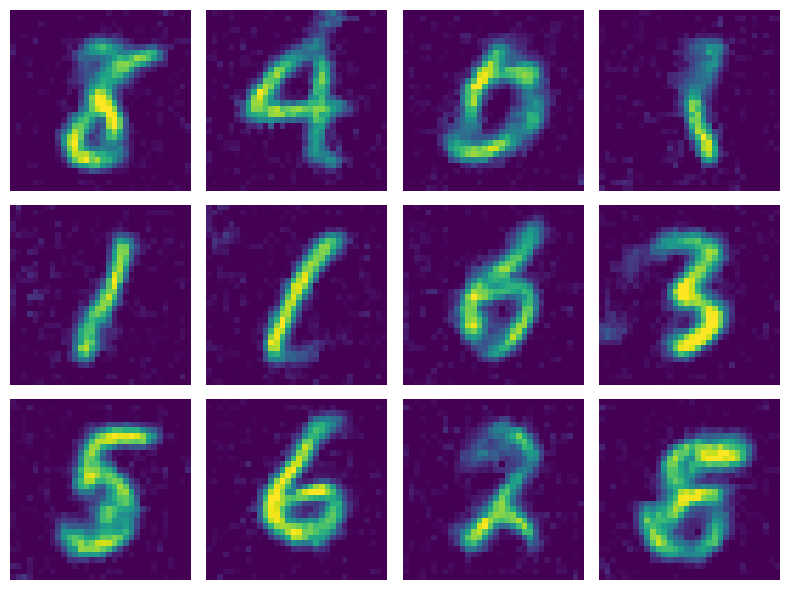

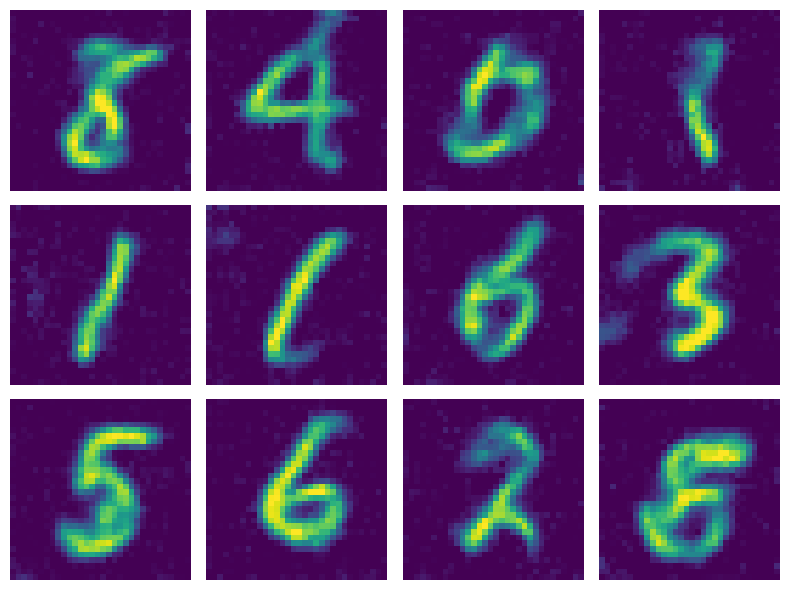

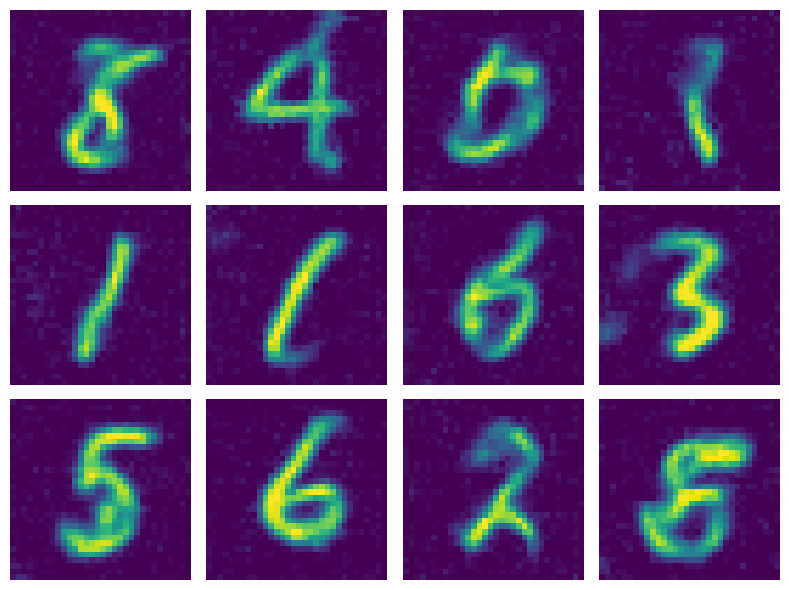

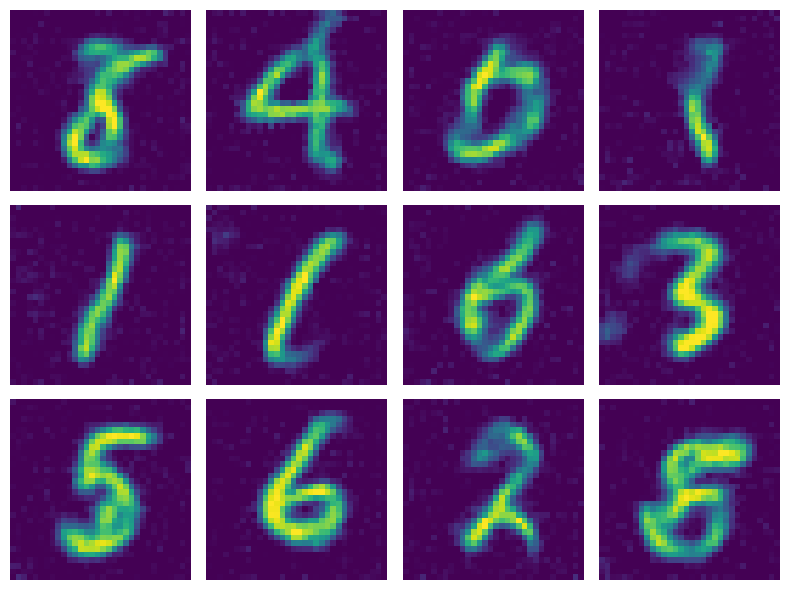

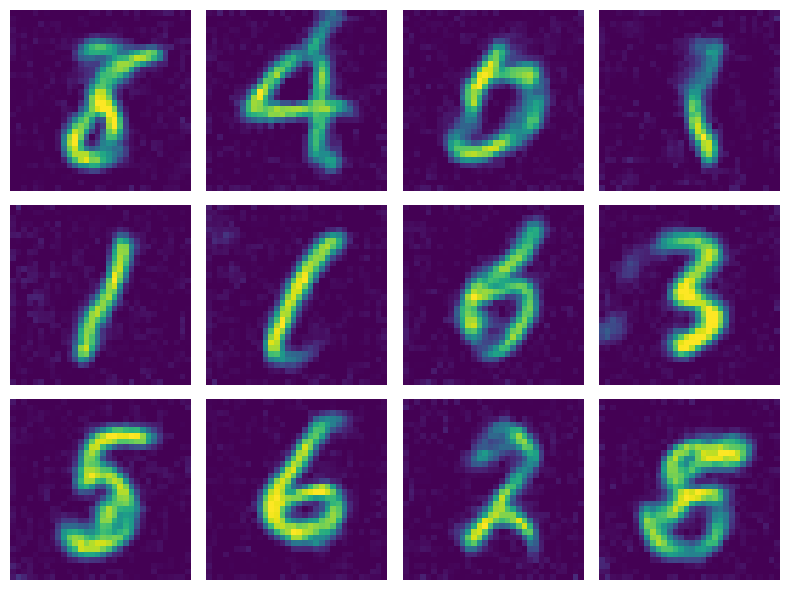

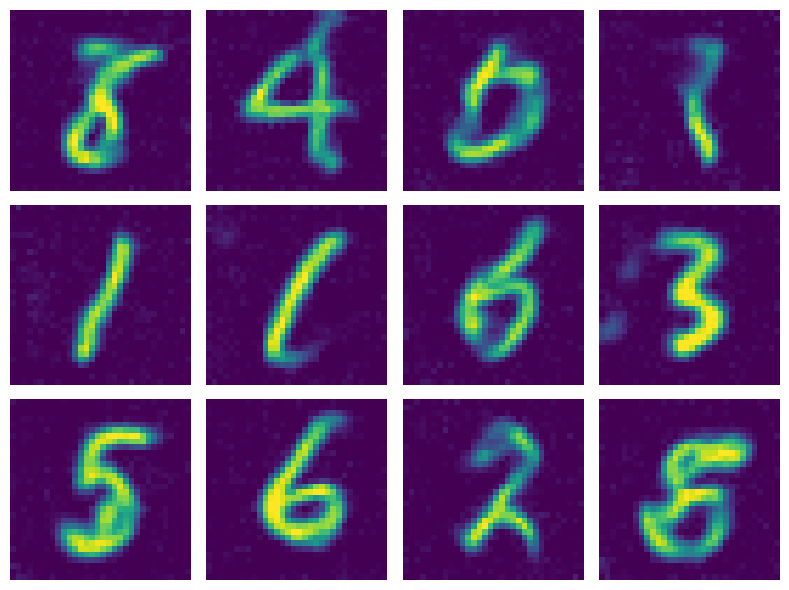

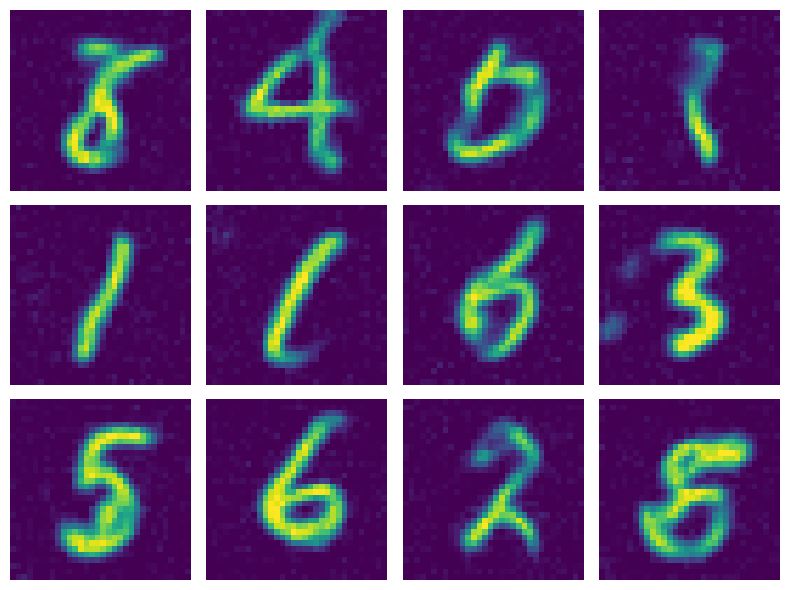

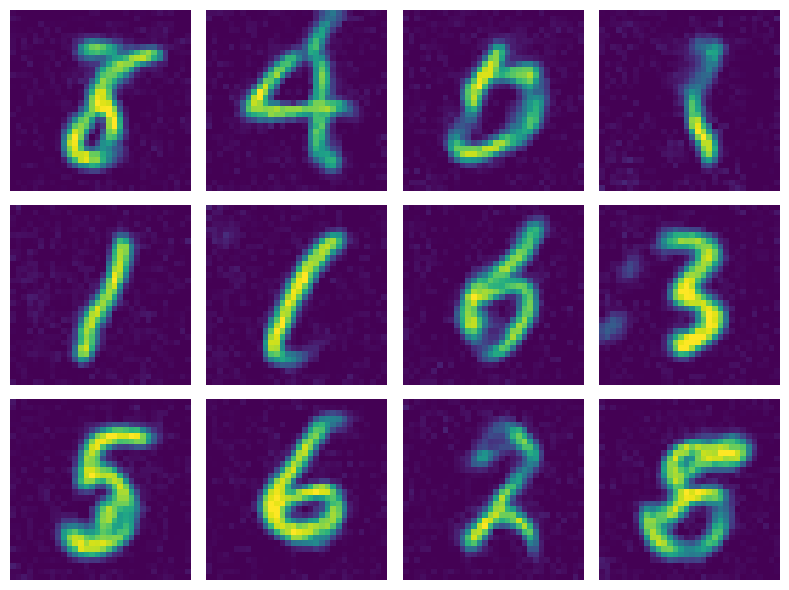

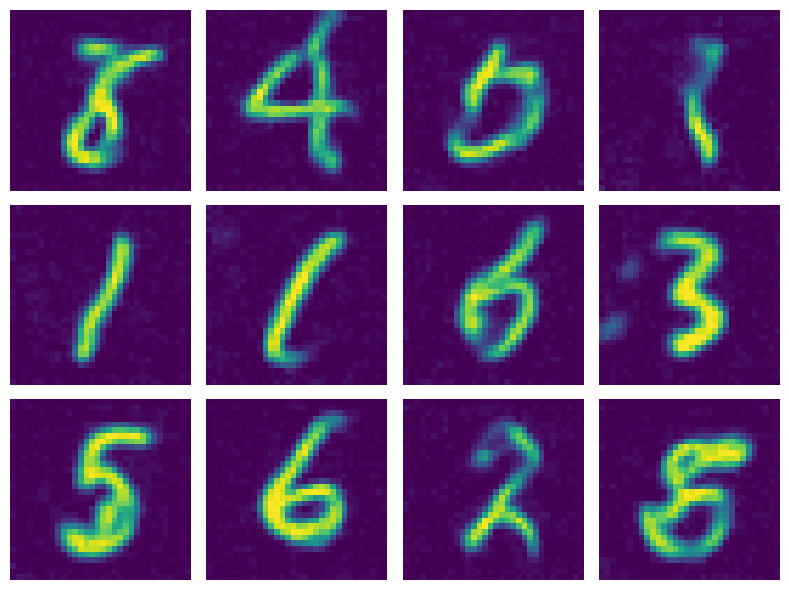

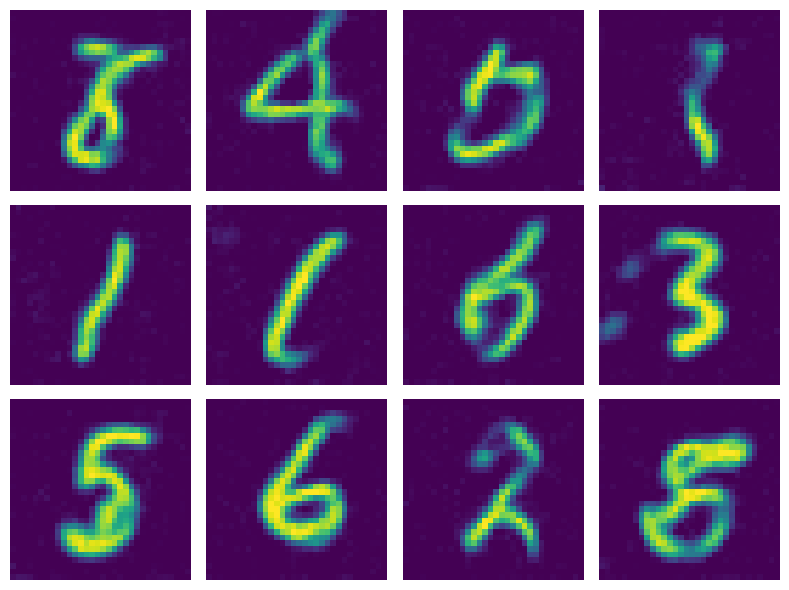

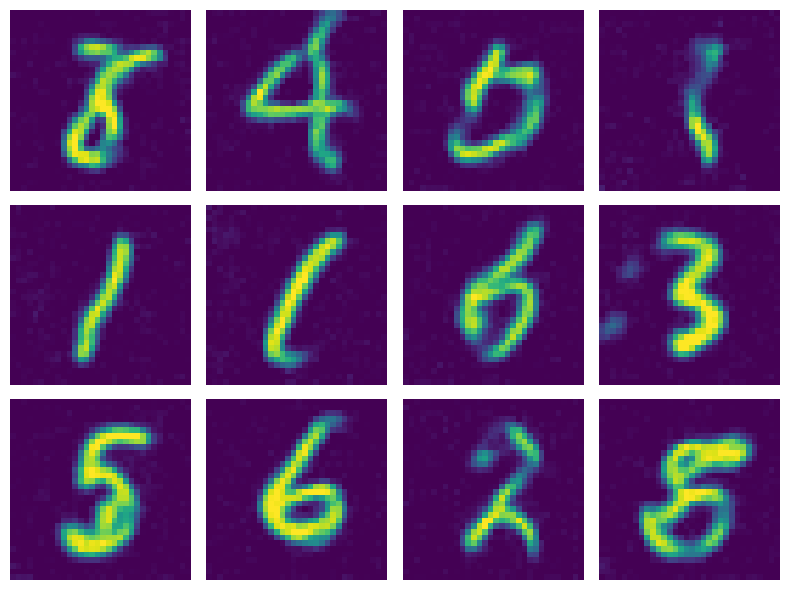

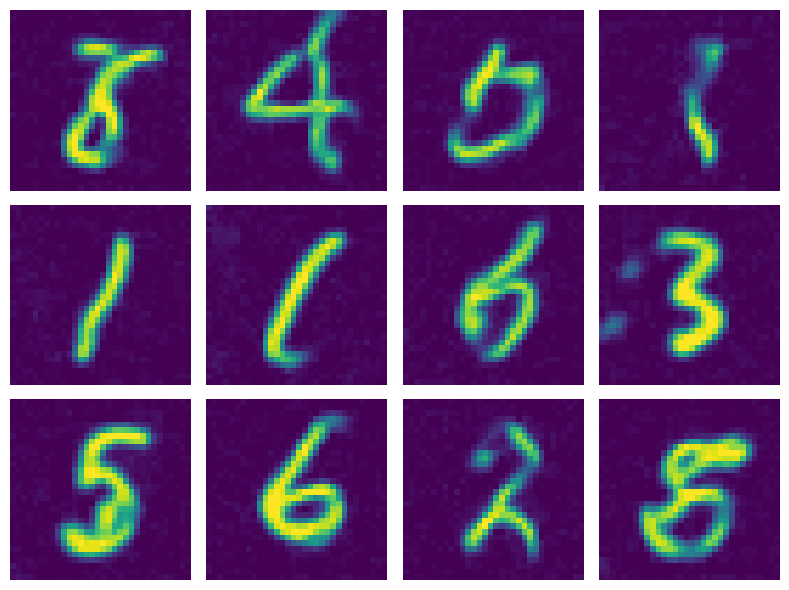

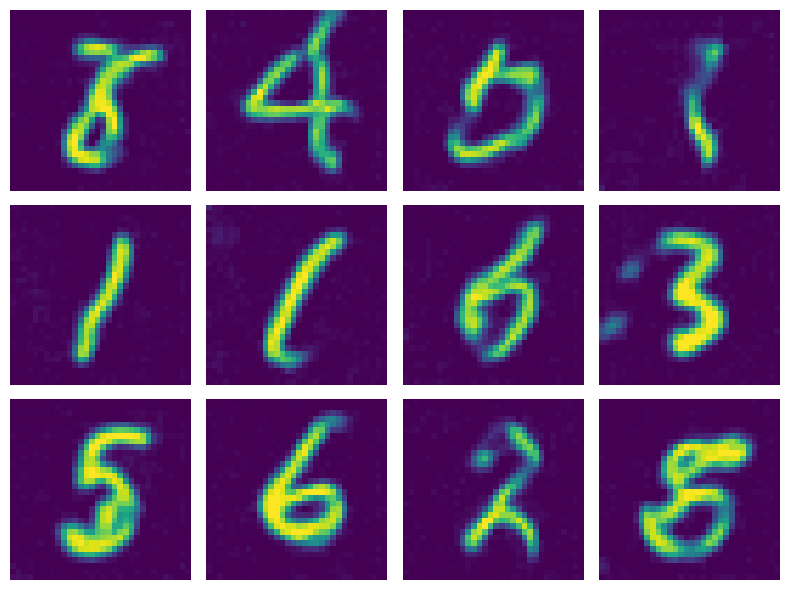

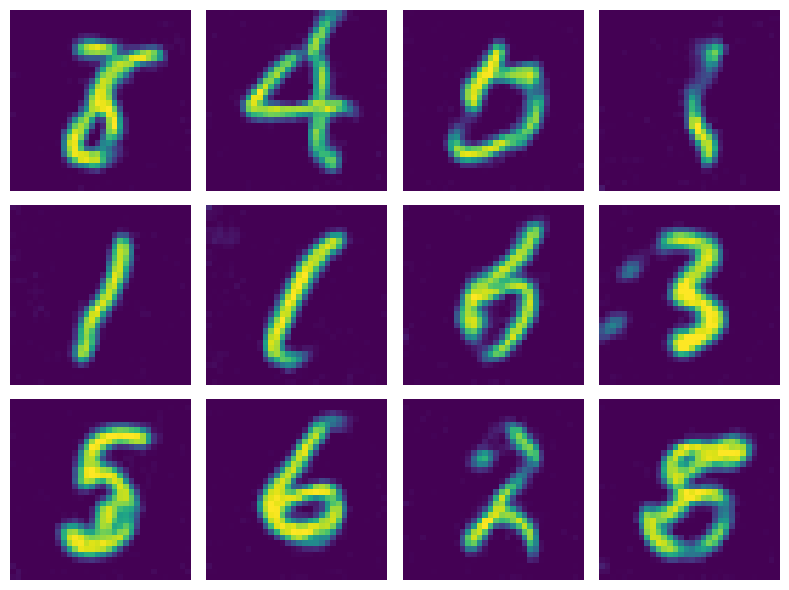

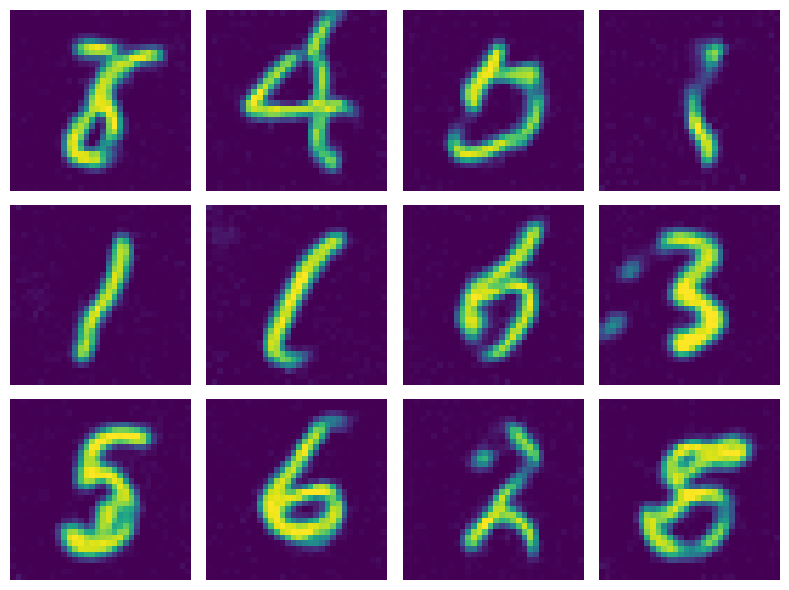

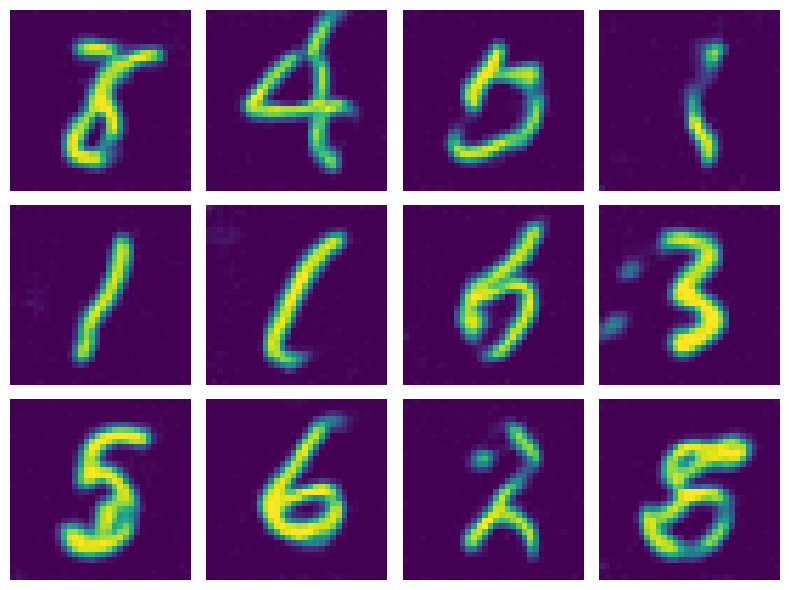

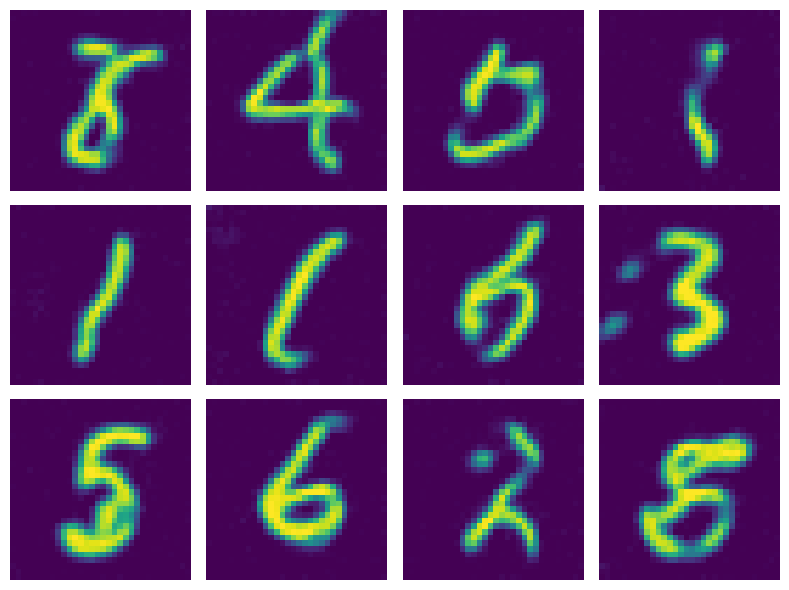

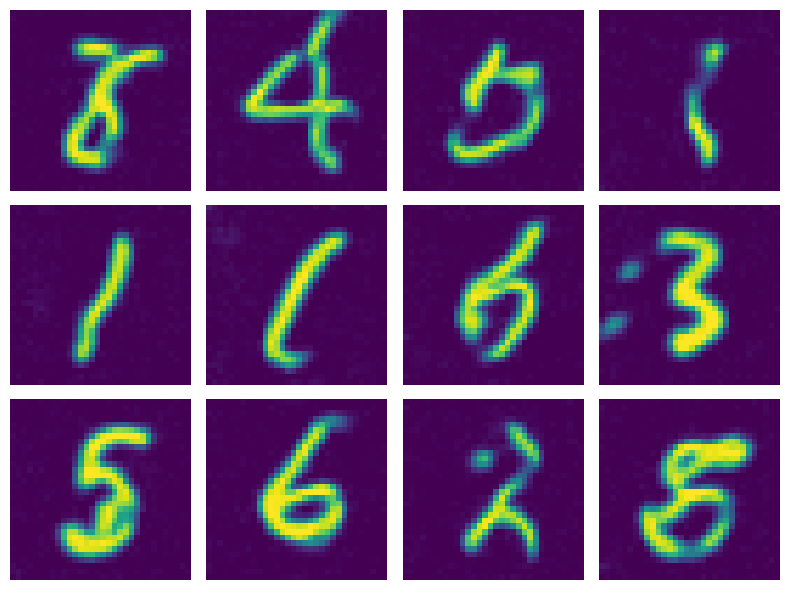

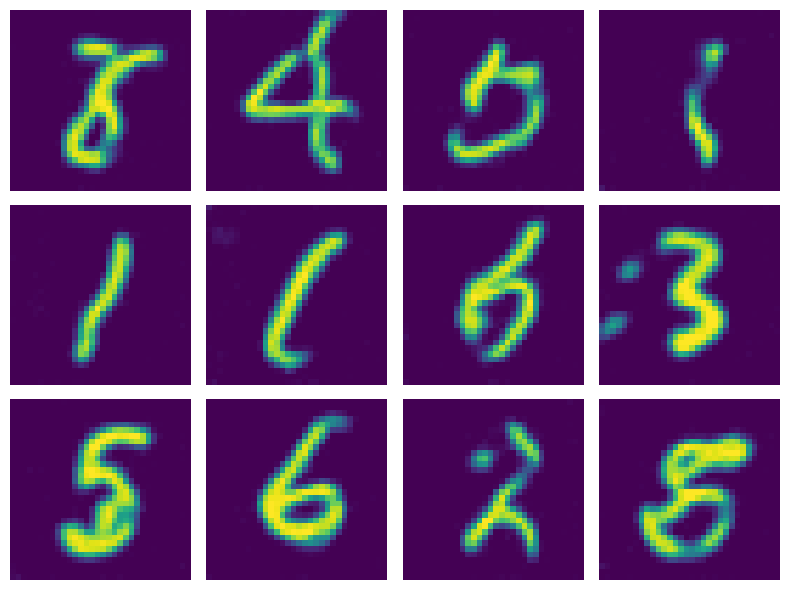

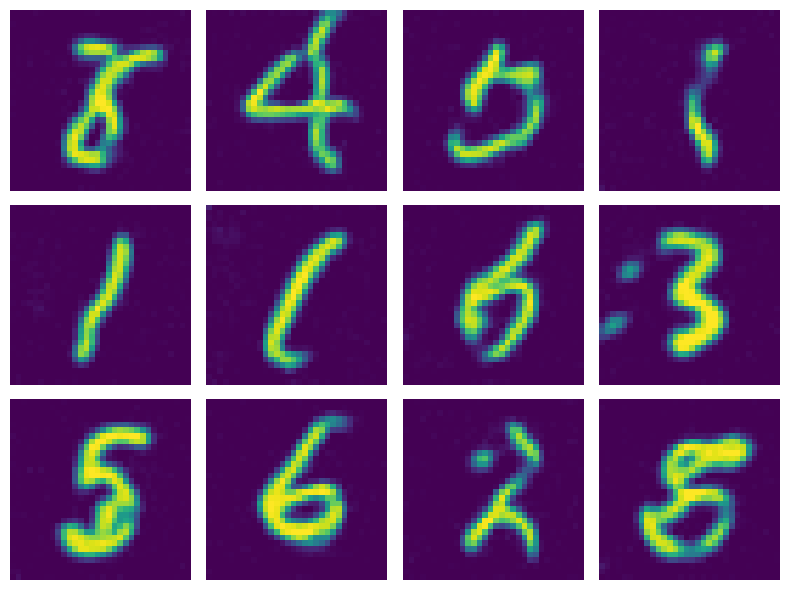

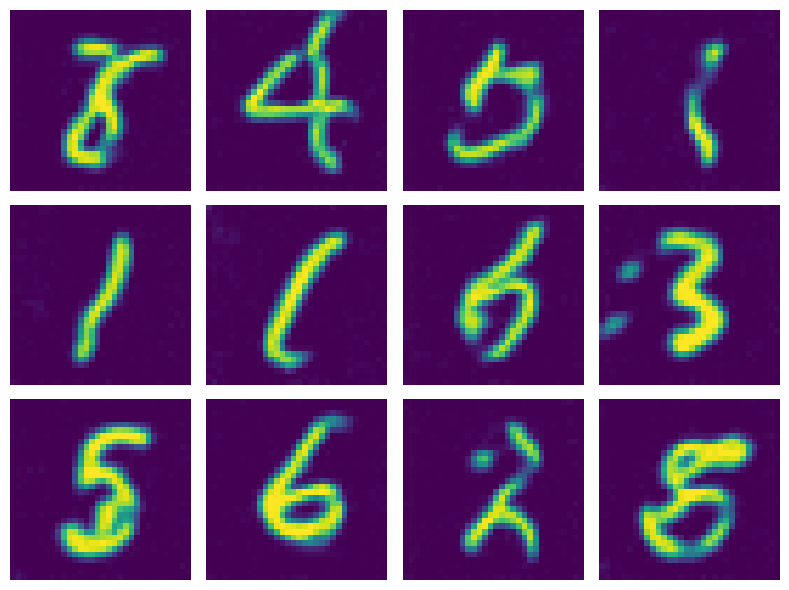

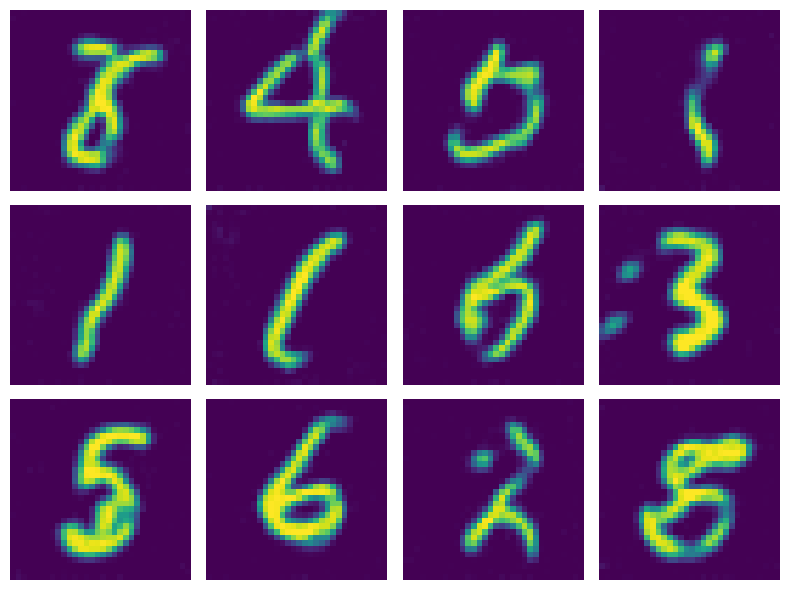

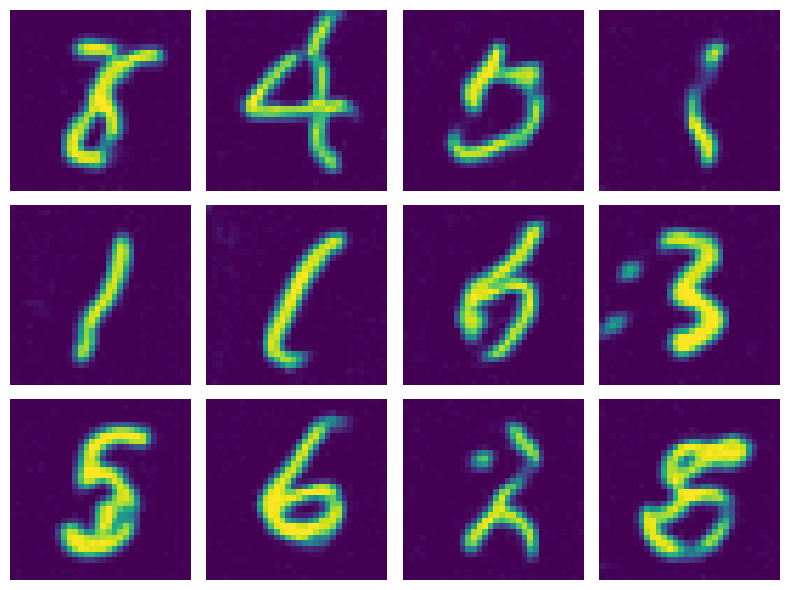

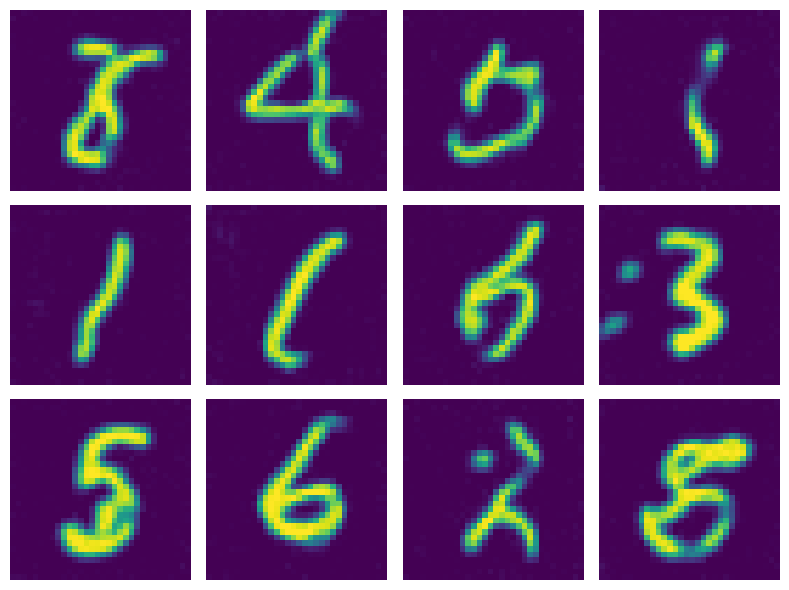

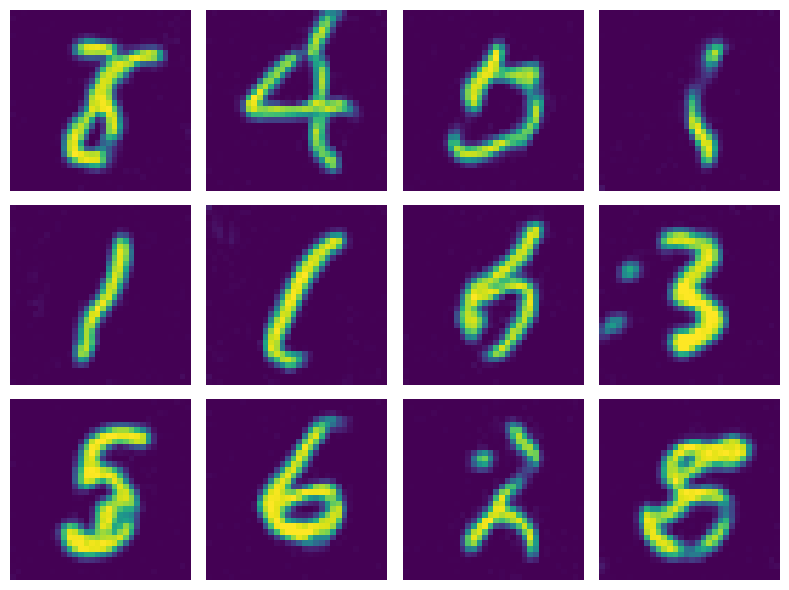

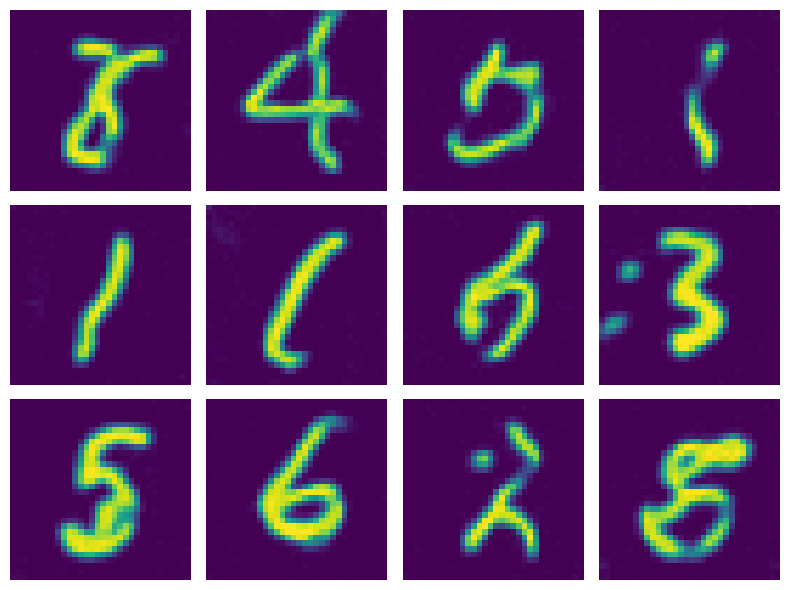

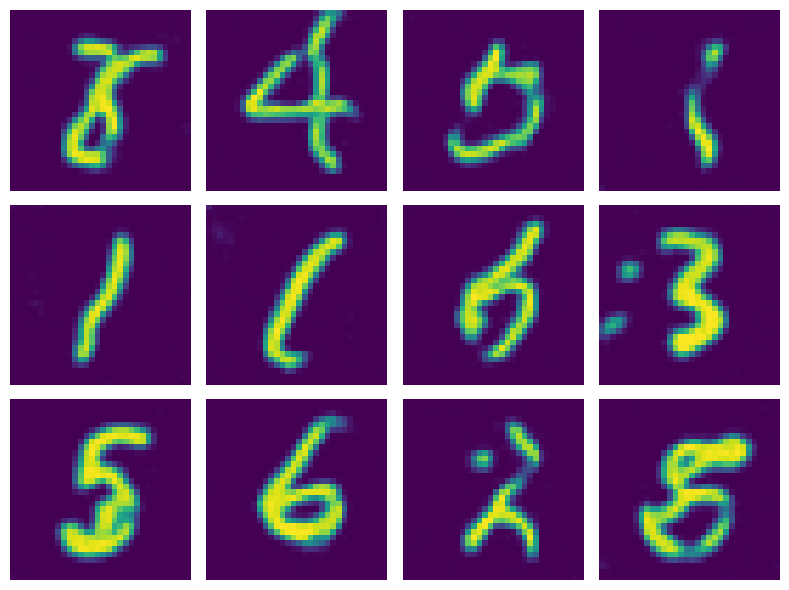

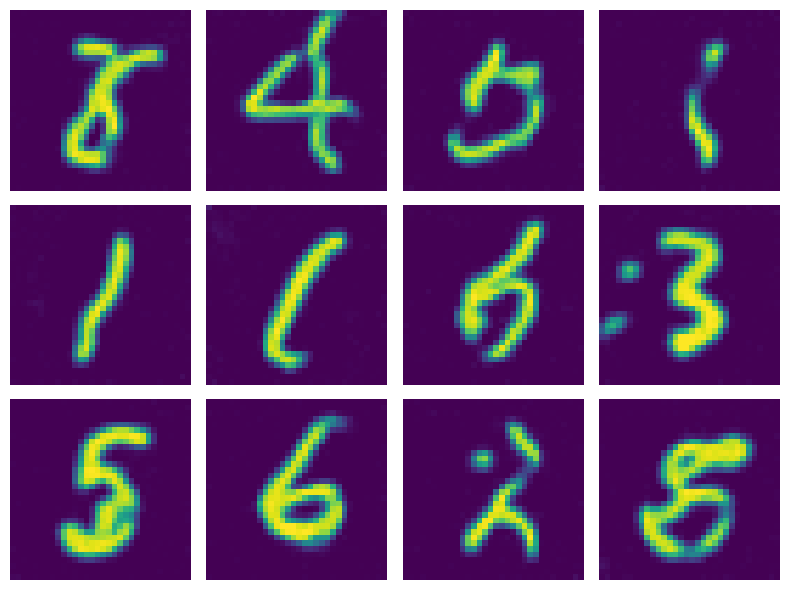

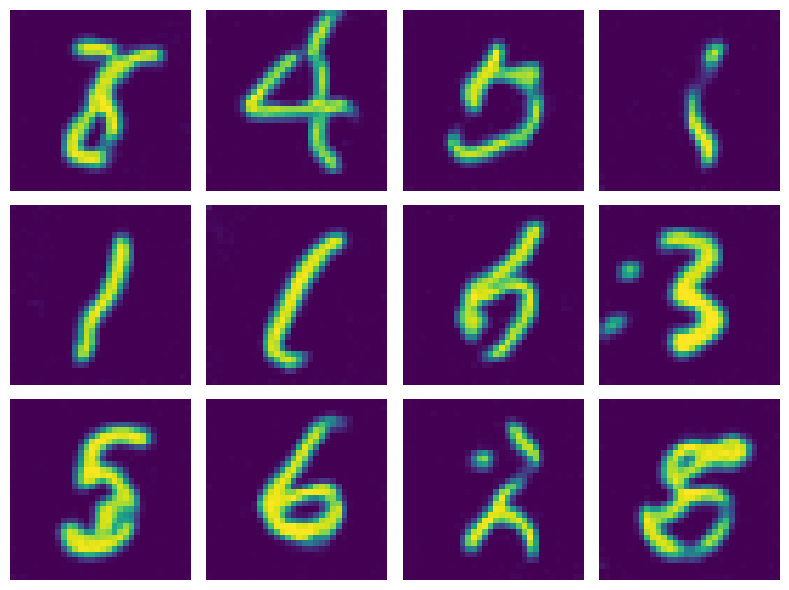

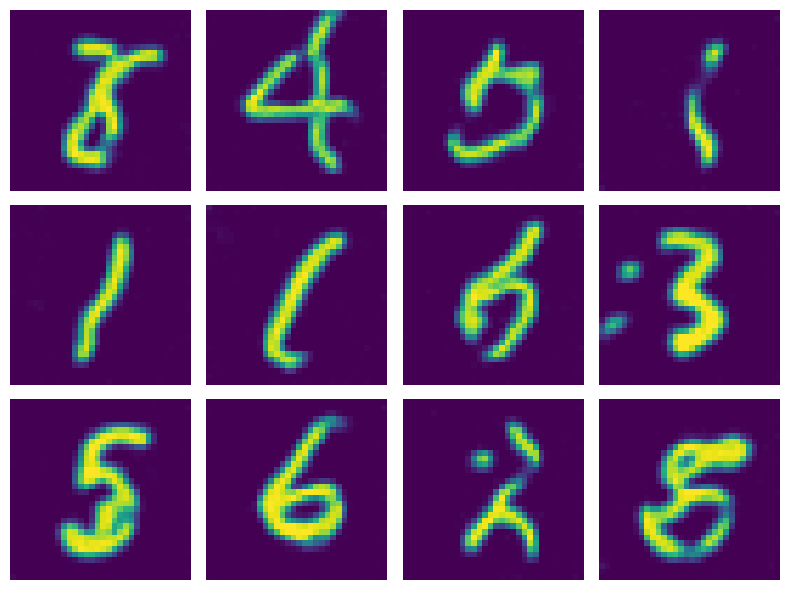

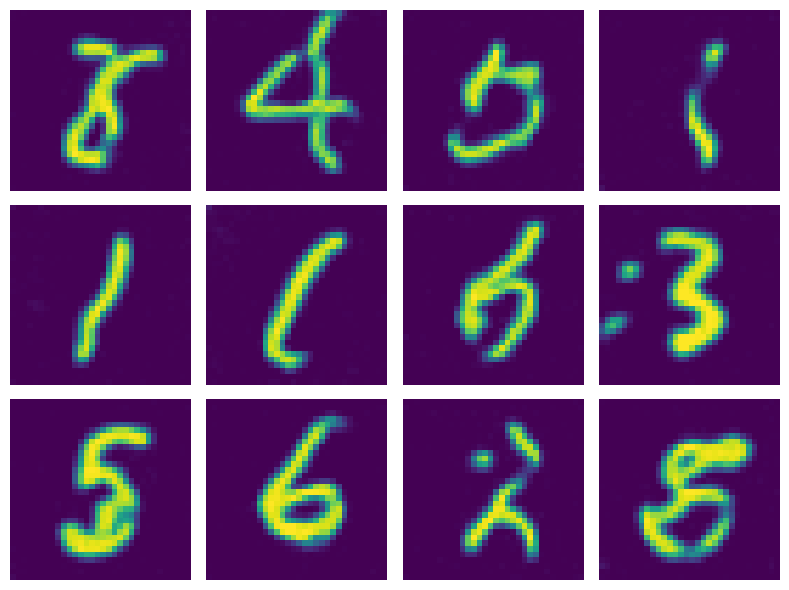

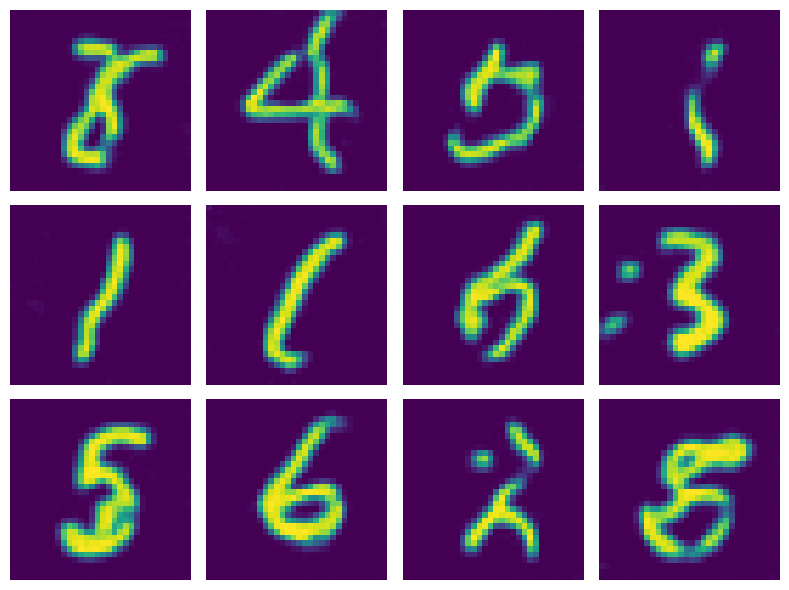

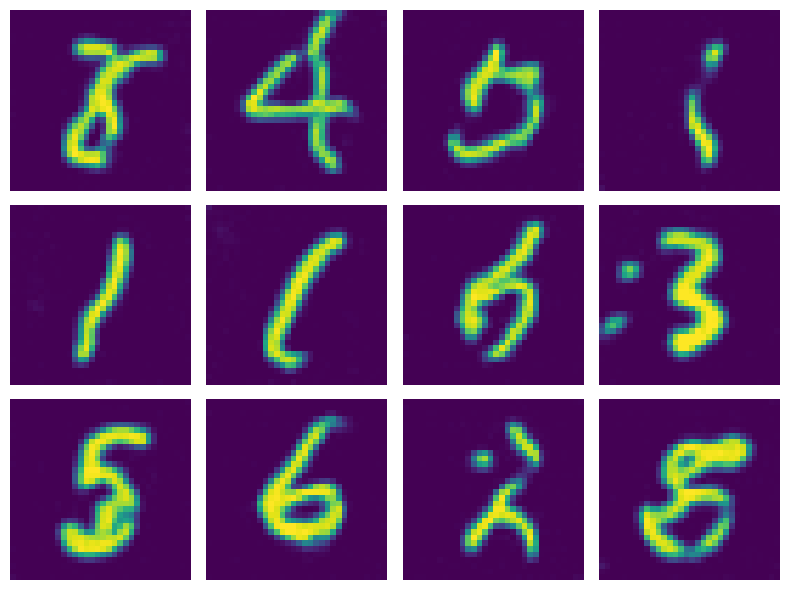

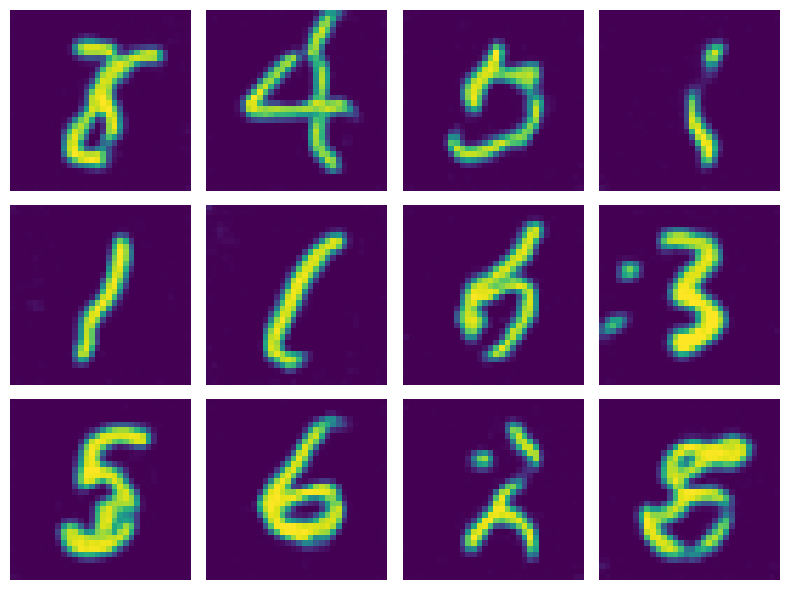

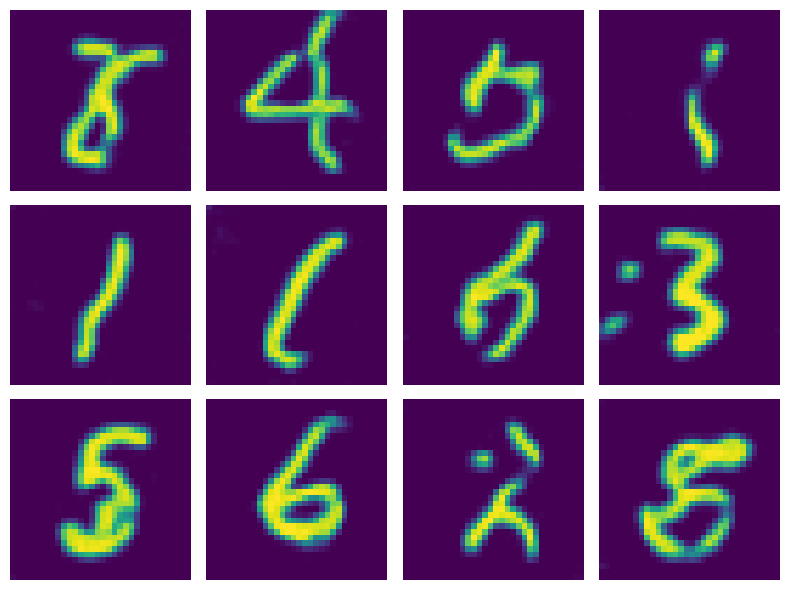

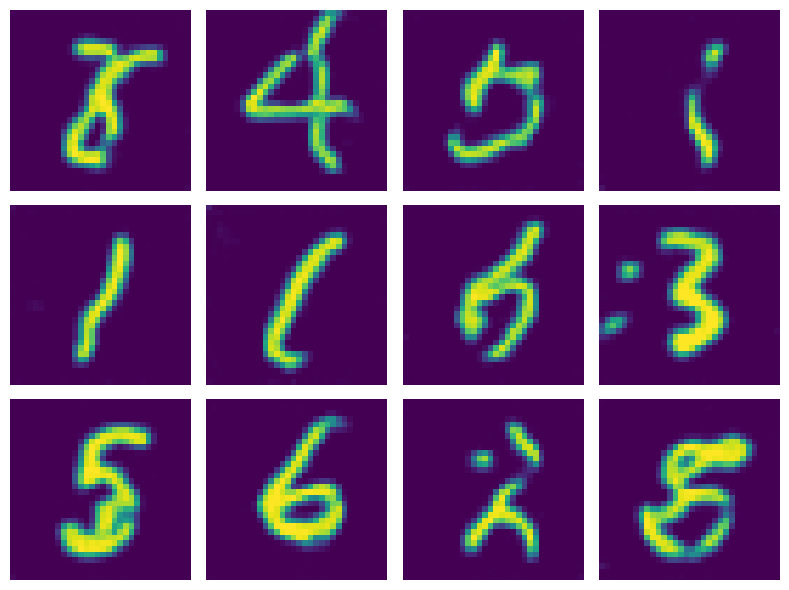

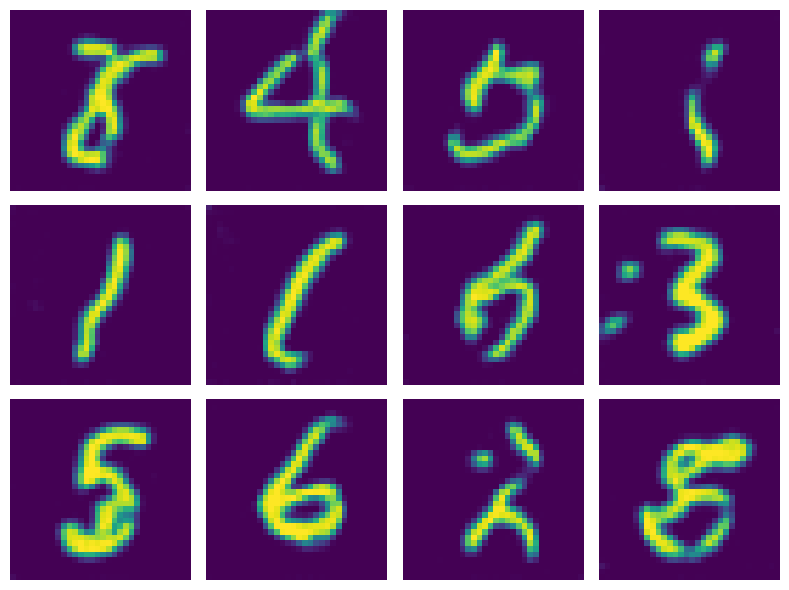

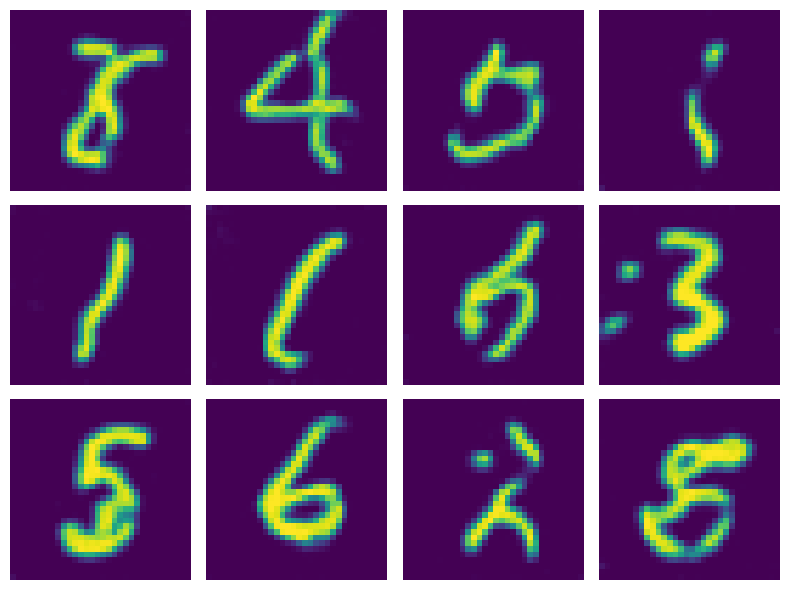

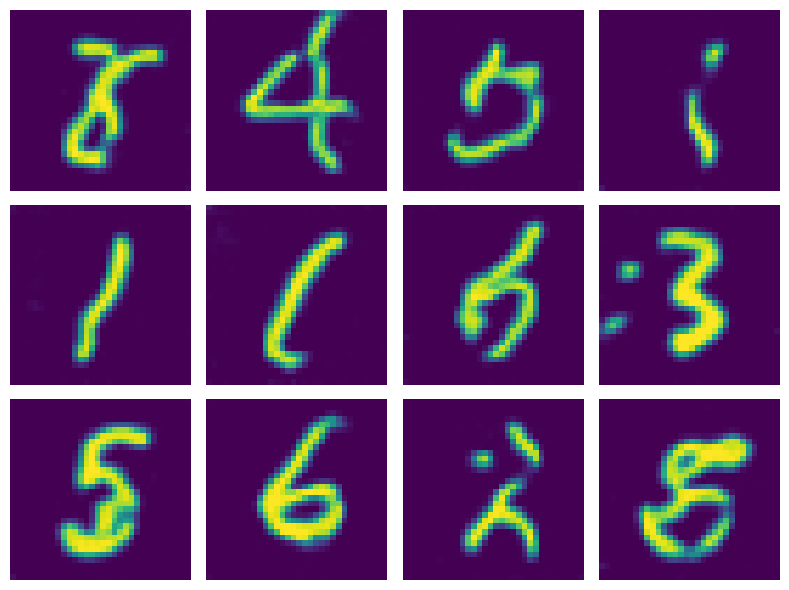

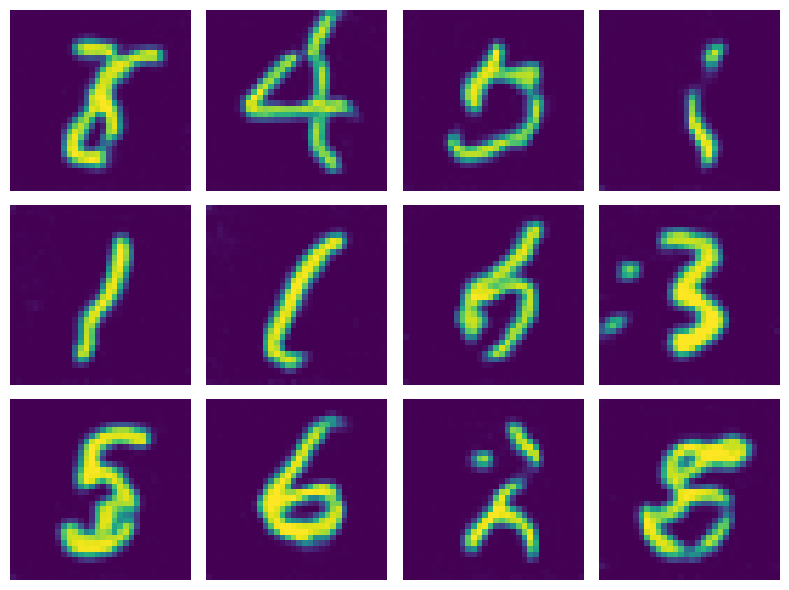

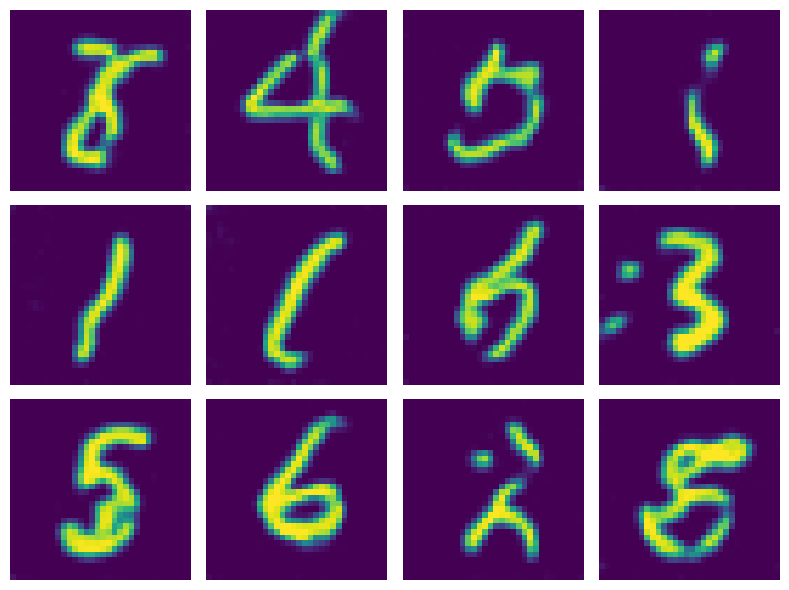

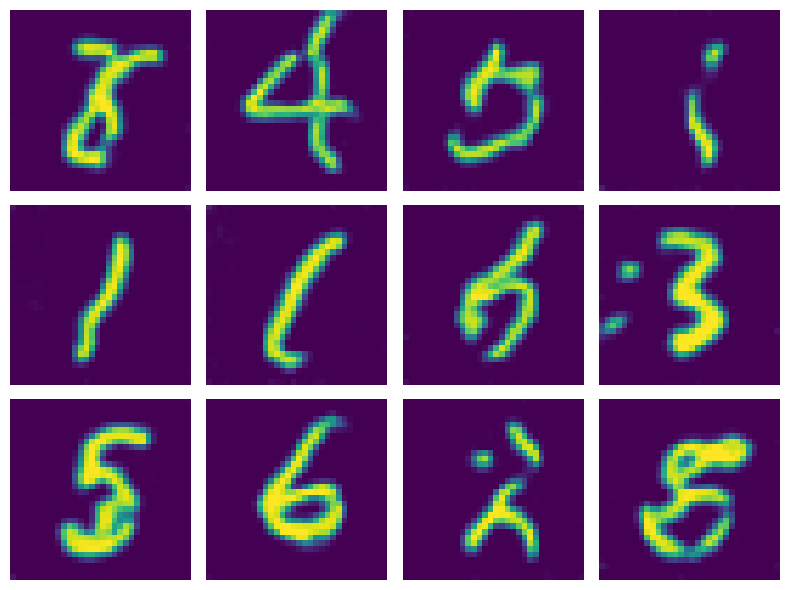

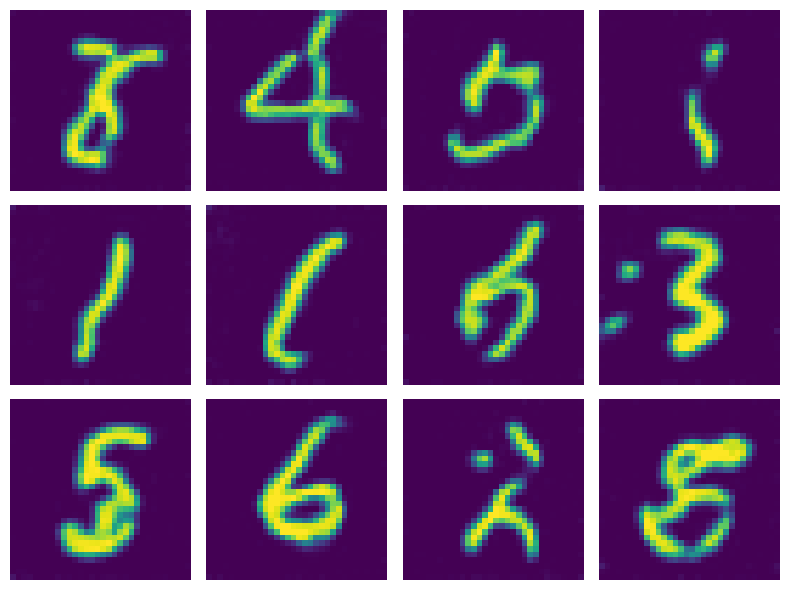

In [97]:
save_images(3, 4, 50)

In [87]:
def last_char(x):
    return x.split('.')[0][-2:]

In [100]:
import imageio

anim_file = 'diffusionex.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = os.listdir('.\saved_images')
    filenames = sorted(filenames, key=last_char)
    for filename in filenames:
        print(filename)
        image = imageio.imread('.\\saved_images\\'+filename)
        writer.append_data(image)
    #image = imageio.imread('.\\pics3\\images3\\'+filename)
    #writer.append_data(image)

image at step 0.jpg


C:\Users\SHOCKER\AppData\Local\Temp\ipykernel_12872\23051400.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('.\\saved_images\\'+filename)


image at step 1.jpg
image at step 2.jpg
image at step 3.jpg
image at step 4.jpg
image at step 5.jpg
image at step 6.jpg
image at step 7.jpg
image at step 8.jpg
image at step 9.jpg
image at step 10.jpg
image at step 11.jpg
image at step 12.jpg
image at step 13.jpg
image at step 14.jpg
image at step 15.jpg
image at step 16.jpg
image at step 17.jpg
image at step 18.jpg
image at step 19.jpg
image at step 20.jpg
image at step 21.jpg
image at step 22.jpg
image at step 23.jpg
image at step 24.jpg
image at step 25.jpg
image at step 26.jpg
image at step 27.jpg
image at step 28.jpg
image at step 29.jpg
image at step 30.jpg
image at step 31.jpg
image at step 32.jpg
image at step 33.jpg
image at step 34.jpg
image at step 35.jpg
image at step 36.jpg
image at step 37.jpg
image at step 38.jpg
image at step 39.jpg
image at step 40.jpg
image at step 41.jpg
image at step 42.jpg
image at step 43.jpg
image at step 44.jpg
image at step 45.jpg
image at step 46.jpg
image at step 47.jpg
image at step 48.jpg
i